In [121]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame


In [122]:
client = CryptoHistoricalDataClient()

In [123]:
from datetime import timedelta

# Use last 60 days of minute bars — enough data without being millions of rows
start_date = datetime.now() - timedelta(days=60)

request_params = CryptoBarsRequest(
    symbol_or_symbols=["BTC/USD"],
    timeframe=TimeFrame.Minute,
    start=start_date,
)

btc_bars = client.get_crypto_bars(request_params)
raw_df = btc_bars.df.reset_index()
raw_df = raw_df[raw_df["symbol"] == "BTC/USD"].copy()

print(f"Rows: {len(raw_df):,}  |  "
      f"From: {raw_df['timestamp'].min()}  →  {raw_df['timestamp'].max()}")
raw_df.head()

Rows: 82,902  |  From: 2025-12-25 12:43:00+00:00  →  2026-02-23 11:41:00+00:00


,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,BTC/USD,2025-12-25 12:43:00+00:00,87474.1250,87474.125,87440.8800,87462.6000,0.0,0.0,87457.50250
1,BTC/USD,2025-12-25 12:44:00+00:00,87442.7495,87475.299,87442.7495,87475.2990,0.0,0.0,87459.02425
2,BTC/USD,2025-12-25 12:45:00+00:00,87450.1785,87462.440,87443.9235,87443.9235,0.0,0.0,87453.18175
3,BTC/USD,2025-12-25 12:46:00+00:00,87469.4500,87469.450,87466.2690,87466.2690,0.0,0.0,87467.85950
4,BTC/USD,2025-12-25 12:47:00+00:00,87468.6100,87468.610,87467.2640,87467.2640,0.0,0.0,87467.93700


# Data preperation

In [124]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = raw_df.copy()

# Target: next minute's closing price
df["target"] = df["close"].shift(-1)
df.dropna(inplace=True)

features = ["open", "volume", "high", "low", "trade_count"]

X = df[features]
y = df["target"]

print(f"Missing values:\n{X.isnull().sum()}")
print(f"\nDataset shape: {X.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale features (required for KNN and Lasso; harmless for tree models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Convert back to DataFrames for convenience
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=features, index=X_test.index)

print(f"\nTrain size: {X_train_scaled.shape}, Test size: {X_test_scaled.shape}")
X_train_scaled.head()


Missing values:
open           0
volume         0
high           0
low            0
trade_count    0
dtype: int64

Dataset shape: (82901, 5)

Train size: (66320, 5), Test size: (16581, 5)


,open,volume,high,low,trade_count
0,0.194708,-0.070248,0.188421,0.195124,-0.335736
1,0.191012,-0.070248,0.188560,0.195344,-0.335736
2,0.191887,-0.070248,0.187037,0.195482,-0.335736
3,0.194157,-0.070248,0.187867,0.198109,-0.335736
4,0.194058,-0.070248,0.187768,0.198226,-0.335736


# Model train

MAE: $46.12
R²:  0.9948


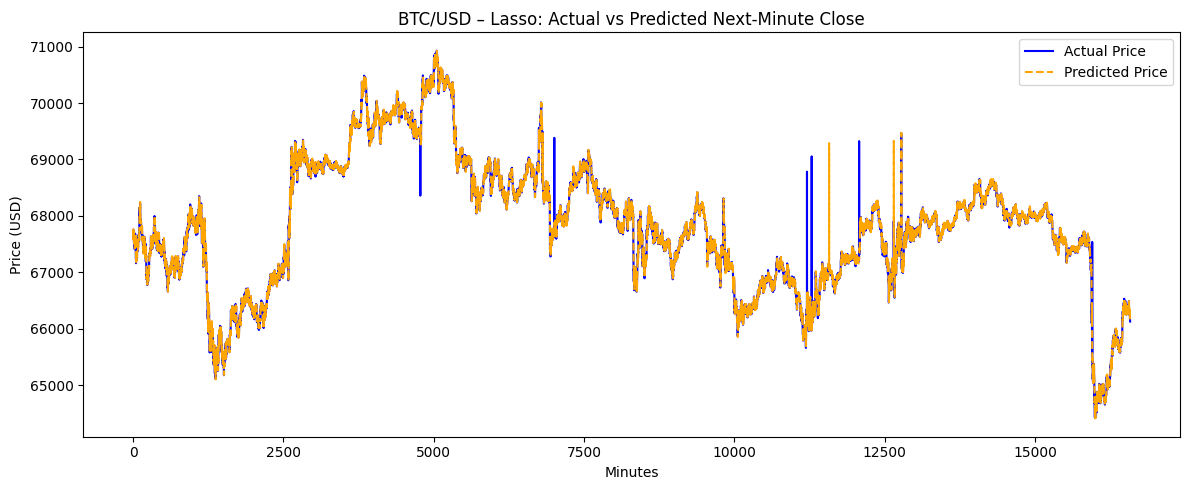

In [125]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, r2_score

lasso = Lasso(alpha=1)
lasso.fit(X_train_scaled, y_train)

# Use X_test_scaled — Lasso was trained on scaled features
predictions = lasso.predict(X_test_scaled)

# Evaluate
mae = mean_absolute_error(y_test, predictions)
r2  = r2_score(y_test, predictions)
print(f"MAE: ${mae:,.2f}")
print(f"R²:  {r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label="Actual Price", color="blue")
plt.plot(predictions, label="Predicted Price", color="orange", linestyle="--")
plt.title("BTC/USD – Lasso: Actual vs Predicted Next-Minute Close")
plt.xlabel("Minutes")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()


## Overfitting / Underfitting Diagnostics

         Train        Test
MAE   $     55.53  $     46.12
R²         0.9999       0.9948

Verdict: GOOD FIT     – train/test scores are close (gap=0.0050).


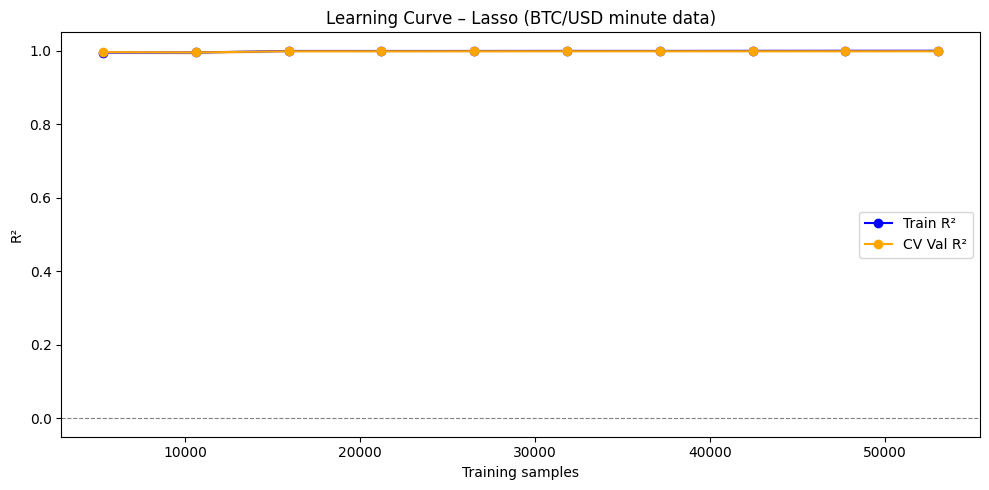

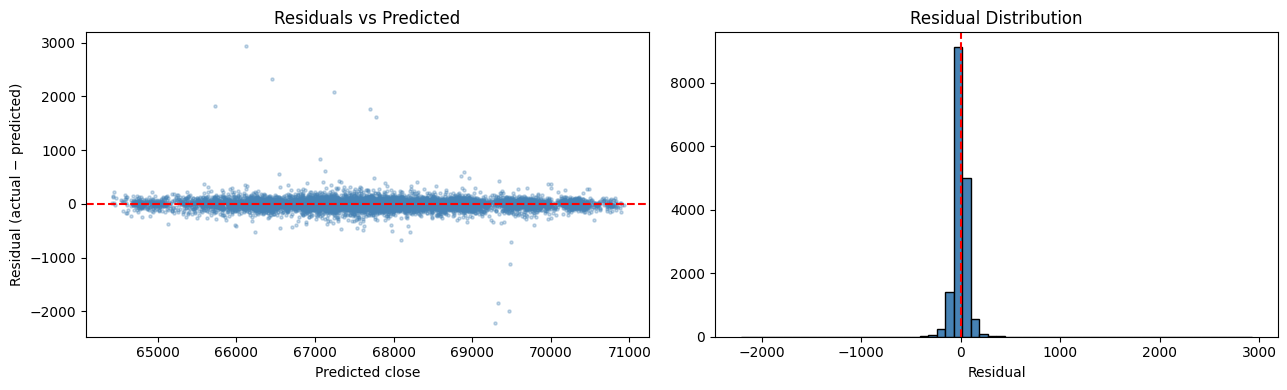

In [126]:
from sklearn.model_selection import learning_curve

# ── 1. Train vs Test scores ───────────────────────────────────────────────────
train_preds = lasso.predict(X_train_scaled)

train_mae = mean_absolute_error(y_train, train_preds)
test_mae  = mean_absolute_error(y_test,  predictions)
train_r2  = r2_score(y_train, train_preds)
test_r2   = r2_score(y_test,  predictions)

print("         Train        Test")
print(f"MAE   ${train_mae:>10,.2f}  ${test_mae:>10,.2f}")
print(f"R²    {train_r2:>11.4f}  {test_r2:>11.4f}")
print()

gap = abs(train_r2 - test_r2)
if train_r2 < 0.7 and test_r2 < 0.7:
    verdict = "UNDERFITTING – model is too simple; both scores are low."
elif gap > 0.1:
    verdict = f"OVERFITTING  – train R²={train_r2:.4f} >> test R²={test_r2:.4f} (gap={gap:.4f})."
else:
    verdict = f"GOOD FIT     – train/test scores are close (gap={gap:.4f})."
print(f"Verdict: {verdict}")

# ── 2. Learning curve ─────────────────────────────────────────────────────────
train_sizes, train_scores, val_scores = learning_curve(
    Lasso(alpha=1), X_train_scaled, y_train,
    cv=5, scoring="r2", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_std    = val_scores.std(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_mean, "o-", color="blue",   label="Train R²")
plt.plot(train_sizes, val_mean,   "o-", color="orange", label="CV Val R²")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color="blue")
plt.fill_between(train_sizes, val_mean   - val_std,   val_mean   + val_std,   alpha=0.15, color="orange")
plt.axhline(0, color="grey", linestyle="--", linewidth=0.8)
plt.title("Learning Curve – Lasso (BTC/USD minute data)")
plt.xlabel("Training samples")
plt.ylabel("R²")
plt.legend()
plt.tight_layout()
plt.show()

# ── 3. Residuals plot ─────────────────────────────────────────────────────────
residuals = y_test.values - predictions

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].scatter(predictions, residuals, alpha=0.3, s=5, color="steelblue")
axes[0].axhline(0, color="red", linestyle="--")
axes[0].set_xlabel("Predicted close")
axes[0].set_ylabel("Residual (actual − predicted)")
axes[0].set_title("Residuals vs Predicted")

axes[1].hist(residuals, bins=60, edgecolor="black", color="steelblue")
axes[1].axvline(0, color="red", linestyle="--")
axes[1].set_xlabel("Residual")
axes[1].set_title("Residual Distribution")

plt.tight_layout()
plt.show()


# Next-5-Minutes Prediction Bot

In [127]:
# Retrain on ALL available minute data for the most up-to-date model
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

scaler_full = StandardScaler()
X_full = df[features]
y_full = df["target"]

X_full_scaled = scaler_full.fit_transform(X_full)
X_full_scaled = pd.DataFrame(X_full_scaled, columns=features, index=X_full.index)

lasso_full = Lasso(alpha=1)
lasso_full.fit(X_full_scaled, y_full)
print("Model retrained on full minute dataset.")

Model retrained on full minute dataset.


Last known candle : 2026-02-23 06:41 (ET)  close=$66,127.26

  06:42 ET  →  predicted close: $ 66,129.05  (+1.79  ▲)
  06:43 ET  →  predicted close: $ 66,130.85  (+1.79  ▲)
  06:44 ET  →  predicted close: $ 66,132.64  (+1.79  ▲)
  06:45 ET  →  predicted close: $ 66,134.43  (+1.79  ▲)
  06:46 ET  →  predicted close: $ 66,136.23  (+1.79  ▲)


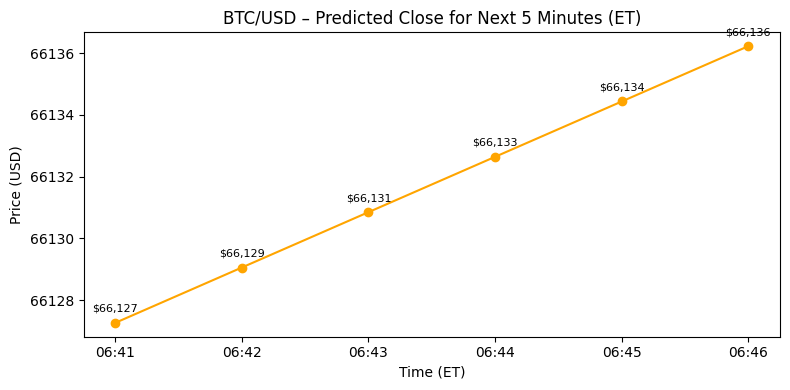

In [128]:
# Predict the next 5 minutes iteratively
# Each step: predicted close becomes the open of the next candle
# Volume / trade_count / high / low are carried forward from the last known candle
import pytz

eastern = pytz.timezone("America/New_York")  # handles EST/EDT automatically

last      = raw_df.iloc[-1]
last_time = pd.to_datetime(last["timestamp"], utc=True).astimezone(eastern)

print(f"Last known candle : {last_time.strftime('%Y-%m-%d %H:%M')} (ET)  close=${last['close']:,.2f}\n")

# Seed the rolling state with the last real candle
state = {
    "open":        last["open"],
    "high":        last["high"],
    "low":         last["low"],
    "volume":      last["volume"],
    "trade_count": last["trade_count"],
    "close":       last["close"],
}

results = []
for step in range(1, 6):
    future_time = last_time + pd.Timedelta(minutes=step)

    feat = pd.DataFrame([{
        "open":        state["close"],
        "volume":      state["volume"],
        "high":        max(state["high"], state["close"]),
        "low":         min(state["low"],  state["close"]),
        "trade_count": state["trade_count"],
    }])[features]   # enforce column order to match scaler fit

    # Keep as DataFrame so Lasso receives named features (no warnings)
    feat_scaled = pd.DataFrame(
        scaler_full.transform(feat), columns=features
    )

    pred_close = lasso_full.predict(feat_scaled)[0]
    move       = pred_close - state["close"]
    arrow      = "▲" if move >= 0 else "▼"

    print(f"  {future_time.strftime('%H:%M')} ET  →  predicted close: ${pred_close:>10,.2f}  "
          f"({move:+,.2f}  {arrow})")

    results.append({"time": future_time.strftime("%H:%M"), "predicted_close": pred_close})

    # Roll state forward
    state = {
        "open":        state["close"],
        "high":        max(state["high"], pred_close),
        "low":         min(state["low"],  pred_close),
        "volume":      state["volume"],
        "trade_count": state["trade_count"],
        "close":       pred_close,
    }

# Plot the forecast
future_df = pd.DataFrame(results)
times  = [last_time.strftime("%H:%M")] + future_df["time"].tolist()
prices = [last["close"]]               + future_df["predicted_close"].tolist()

plt.figure(figsize=(8, 4))
plt.plot(times, prices, marker="o", color="orange")
for i, (t, p) in enumerate(zip(times, prices)):
    plt.annotate(f"${p:,.0f}", (t, p), textcoords="offset points",
                 xytext=(0, 8), ha="center", fontsize=8)
plt.title("BTC/USD – Predicted Close for Next 5 Minutes (ET)")
plt.xlabel("Time (ET)")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.show()


66,169.75